<a href="https://colab.research.google.com/github/Laksopan23/Brain-Tumor-Detection-Models/blob/sageevan-yolo/YOLO11n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Phase 0 — Environment Setup

In [1]:
!pip install -q ultralytics==8.3.40 scikit-learn matplotlib pandas pillow opencv-python

import os, glob, shutil, random, math
from pathlib import Path
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import cv2

from sklearn.metrics import confusion_matrix, classification_report
from ultralytics import YOLO

plt.rcParams.update({"figure.figsize": (6,4), "figure.dpi": 120, "axes.grid": True})
random.seed(42)
np.random.seed(42)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 898.5/898.5 kB 13.5 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


## Phase 1 — Dataset Exploration

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
data_dir = "/content/drive/MyDrive/DL_Project"
classes = ["glioma", "meningioma", "pituitary", "notumor"]

In [20]:
# Count images per class
image_counts = {}
for cls in classes:
    cls_dir = os.path.join(data_dir, cls)
    files = [f for f in os.listdir(cls_dir) if f.lower().endswith(('.jpg','.jpeg','.png','.bmp','.tif','.tiff'))]
    image_counts[cls] = len(files)

print("Total Images per Class:")
for cls, count in image_counts.items():
    print(f"{cls}: {count}")

Total Images per Class:
glioma: 1621
meningioma: 1645
pituitary: 1757
notumor: 2000


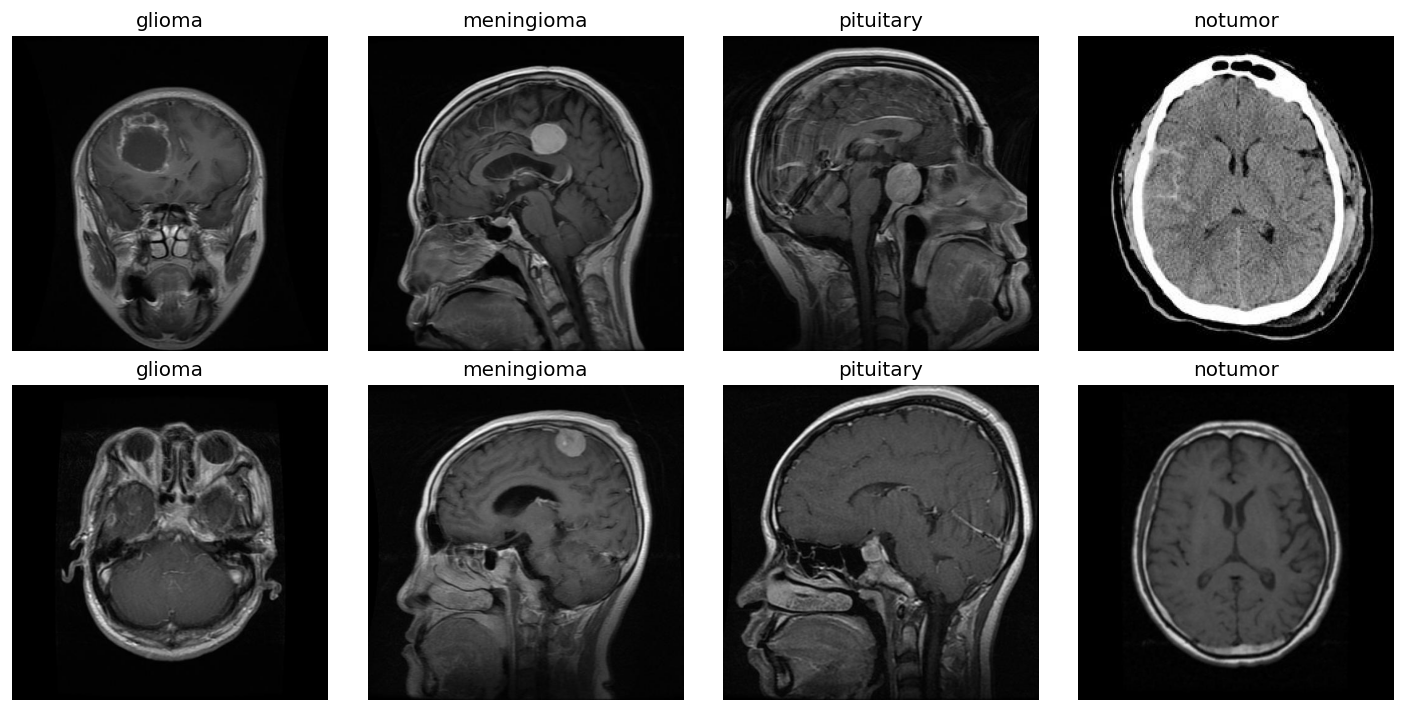

In [21]:
# Show random images per class
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for i, cls in enumerate(classes):
    img_dir = os.path.join(data_dir, cls)
    files = [f for f in os.listdir(img_dir) if f.lower().endswith(('.jpg','.jpeg','.png','.bmp','.tif','.tiff'))]
    sample_imgs = random.sample(files, min(2, len(files))) if files else []
    for j, img_name in enumerate(sample_imgs):
        img_path = os.path.join(img_dir, img_name)
        img = cv2.imread(img_path)
        if img is None:
            axes[j, i].set_title(f"{cls} (unreadable)")
            axes[j, i].axis("off")
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[j, i].imshow(img)
        axes[j, i].set_title(f"{cls}")
        axes[j, i].axis("off")
    # fill missing slots if class has <2 images
    for j in range(len(sample_imgs), 2):
        axes[j, i].axis("off")

plt.tight_layout()
plt.show()

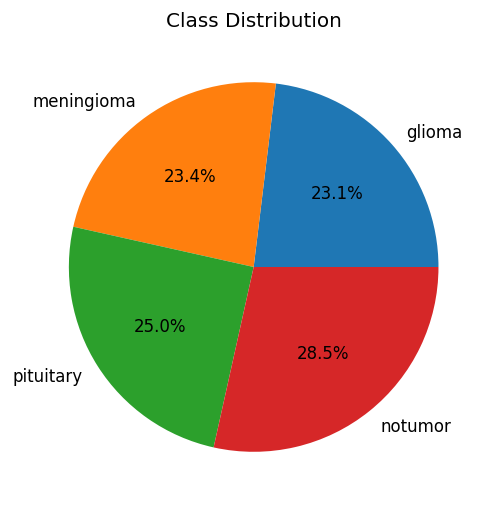

In [22]:
# Class distribution pie chart
labels = list(image_counts.keys())
sizes = list(image_counts.values())

plt.figure(figsize=(5, 5))
plt.pie(sizes, labels=labels, autopct="%1.1f%%")
plt.title("Class Distribution")
plt.show()

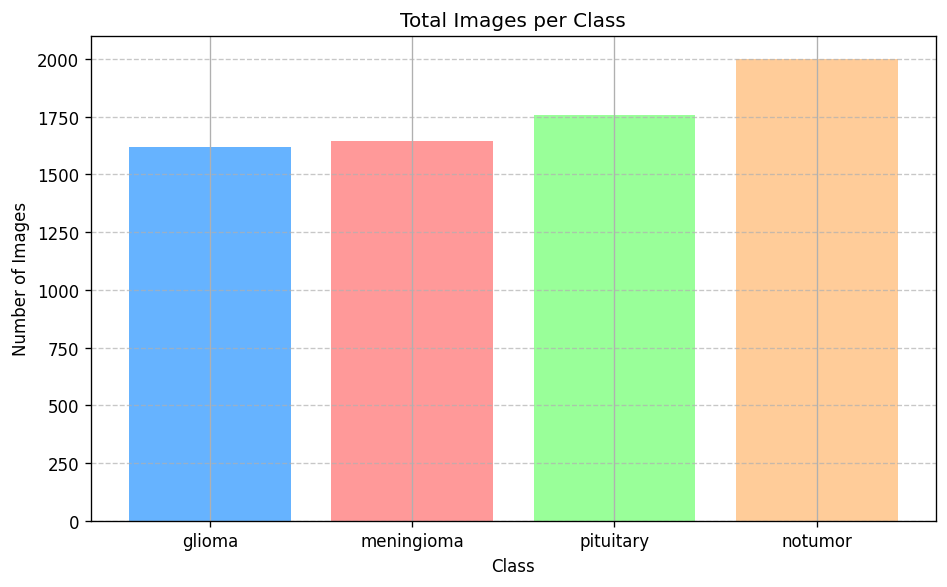

In [23]:
plt.figure(figsize=(8, 5))
plt.bar(image_counts.keys(), image_counts.values(),
        color=["#66b3ff", "#ff9999", "#99ff99", "#ffcc99"])
plt.title("Total Images per Class")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## Phase 2 — Dataset Preparation & Splitting

In [24]:
HAS_SPLIT = False

SPLIT_ROOT = "/content/drive/MyDrive/DL_Project_SPLIT"
TRAIN_DIR = Path(SPLIT_ROOT) / "train"
VAL_DIR   = Path(SPLIT_ROOT) / "val"
TEST_DIR  = Path(SPLIT_ROOT) / "test"

SPLIT = (0.7, 0.15, 0.15)  # train/val/test ratios
RANDOM_SEED = 42

def copy_split_from_single_root(root_dir, classes, out_train, out_val, out_test, split=(0.7,0.15,0.15), seed=42):
    os.makedirs(out_train, exist_ok=True)
    os.makedirs(out_val, exist_ok=True)
    os.makedirs(out_test, exist_ok=True)
    random.seed(seed)

    for cls in classes:
        src = Path(root_dir) / cls
        imgs = [p for p in src.iterdir() if p.suffix.lower() in (".jpg",".jpeg",".png",".bmp",".tif",".tiff")]
        random.shuffle(imgs)
        n = len(imgs)
        n_train = int(n * split[0])
        n_val   = int(n * split[1])

        splits = [
            (imgs[:n_train], Path(out_train) / cls),
            (imgs[n_train:n_train+n_val], Path(out_val) / cls),
            (imgs[n_train+n_val:], Path(out_test) / cls),
        ]

        for arr, dst in splits:
            dst.mkdir(parents=True, exist_ok=True)
            for p in arr:
                shutil.copy2(p, dst / p.name)

if not HAS_SPLIT:
    shutil.rmtree(TRAIN_DIR, ignore_errors=True)
    shutil.rmtree(VAL_DIR, ignore_errors=True)
    shutil.rmtree(TEST_DIR, ignore_errors=True)
    copy_split_from_single_root(data_dir, classes, TRAIN_DIR, VAL_DIR, TEST_DIR, SPLIT, RANDOM_SEED)
    print("Created split under:", SPLIT_ROOT)
else:
    print("Using existing split folders:")
print("Train:", TRAIN_DIR)
print("Val  :", VAL_DIR)
print("Test :", TEST_DIR)

Created split under: /content/drive/MyDrive/DL_Project_SPLIT
Train: /content/drive/MyDrive/DL_Project_SPLIT/train
Val  : /content/drive/MyDrive/DL_Project_SPLIT/val
Test : /content/drive/MyDrive/DL_Project_SPLIT/test


In [29]:
# ---- CALLBACK: write train accuracy each epoch into results.csv ----
from pathlib import Path
import pandas as pd
import numpy as np
from ultralytics import YOLO

IMG_SIZE = 224
BATCH = 32

def _safe_get_acc(results_dict: dict):
    for k in ["metrics/accuracy_top1", "val/metrics/accuracy_top1", "accuracy", "top1_acc", "metrics/accuracy"]:
        if k in results_dict and results_dict[k] is not None:
            return float(results_dict[k])
    return None

def on_fit_epoch_end(trainer):
    """
    After each epoch, evaluate the CURRENT weights on the TRAIN split
    and store 'train/accuracy_top1' in results.csv for this epoch.
    """
    save_dir = Path(trainer.save_dir)
    weights = save_dir / "weights" / "last.pt"

    # 'last.pt' is written by the trainer; if not present (e.g., very first pass), skip this epoch
    if not weights.exists():
        return

    # Wrap the weights in a YOLO object (this exposes .val)
    y = YOLO(str(weights))  # classification model weights -> classification task

    r = y.val(
        data=str(SPLIT_ROOT),
        split="train",
        imgsz=IMG_SIZE,
        batch=BATCH,
        plots=False,
        verbose=False
    )
    acc_train = _safe_get_acc(getattr(r, "results_dict", {}) or {})

    # Update results.csv for this epoch
    csv_path = save_dir / "results.csv"
    if not csv_path.exists():
        return  # safety

    df = pd.read_csv(csv_path)
    if "train/accuracy_top1" not in df.columns:
        df["train/accuracy_top1"] = np.nan

    # trainer.epoch is 0-indexed and matches the 'epoch' column
    df.loc[df["epoch"] == int(trainer.epoch), "train/accuracy_top1"] = acc_train
    df.to_csv(csv_path, index=False)


## Phase 3 — Train YOLOv11n (Classification Mode)

In [30]:
MODEL_NAME = "yolo11n-cls.pt"
EPOCHS = 5
IMG_SIZE = 224
BATCH = 32
PATIENCE = 20
PROJECT = "runs/classify"
RUN_NAME = "bt_yolo11n_assignment"

model = YOLO(MODEL_NAME)
model.add_callback("on_fit_epoch_end", on_fit_epoch_end)

train_results = model.train(
    data=str(SPLIT_ROOT),
    epochs=EPOCHS,
    imgsz=IMG_SIZE,
    batch=BATCH,
    patience=PATIENCE,
    project=PROJECT,
    name=RUN_NAME,
    verbose=True
)
print("Training directory:", getattr(train_results, "save_dir", None) or "runs/classify/...")

New https://pypi.org/project/ultralytics/8.3.221 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.40 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=classify, mode=train, model=yolo11n-cls.pt, data=/content/drive/MyDrive/DL_Project_SPLIT, epochs=5, time=None, patience=20, batch=32, imgsz=224, save=True, save_period=-1, cache=False, device=None, workers=8, project=runs/classify, name=bt_yolo11n_assignment2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks

train: Scanning /content/drive/MyDrive/DL_Project_SPLIT/train... 4914 images, 0 corrupt: 100%|██████████| 4914/4914 [00:00<?, ?it/s]
val: Scanning /content/drive/MyDrive/DL_Project_SPLIT/val... 1052 images, 0 corrupt: 100%|██████████| 1052/1052 [00:00<?, ?it/s]


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 39 weight(decay=0.0), 40 weight(decay=0.0005), 40 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 224 train, 224 val
Using 2 dataloader workers
Logging results to runs/classify/bt_yolo11n_assignment2
Starting training for 5 epochs...

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:08<00:00,  1.94it/s]

                   all      0.909          1


Ultralytics 8.3.40 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n-cls summary (fused): 112 layers, 1,531,148 parameters, 0 gradients, 3.2 GFLOPs
train: /content/drive/MyDrive/DL_Project_SPLIT/train... found 4914 images in 4 classes ✅ 
val: /content/drive/MyDrive/DL_Project_SPLIT/val... found 1052 images in 4 classes ✅ 
test: /content/drive/MyDrive/DL_Project_SPLIT/test... found 1057 images in 4 classes ✅ 


train: Scanning /content/drive/MyDrive/DL_Project_SPLIT/train... 4914 images, 0 corrupt: 100%|██████████| 4914/4914 [00:00<?, ?it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 154/154 [00:44<00:00,  3.43it/s]

                   all      0.928          1
Speed: 0.1ms preprocess, 0.5ms inference, 0.0ms loss, 0.0ms postprocess per image



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:08<00:00,  1.93it/s]

                   all      0.935          1


Ultralytics 8.3.40 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n-cls summary (fused): 112 layers, 1,531,148 parameters, 0 gradients, 3.2 GFLOPs
train: /content/drive/MyDrive/DL_Project_SPLIT/train... found 4914 images in 4 classes ✅ 
val: /content/drive/MyDrive/DL_Project_SPLIT/val... found 1052 images in 4 classes ✅ 
test: /content/drive/MyDrive/DL_Project_SPLIT/test... found 1057 images in 4 classes ✅ 


train: Scanning /content/drive/MyDrive/DL_Project_SPLIT/train... 4914 images, 0 corrupt: 100%|██████████| 4914/4914 [00:00<?, ?it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 154/154 [00:45<00:00,  3.40it/s]

                   all      0.946          1
Speed: 0.1ms preprocess, 0.5ms inference, 0.0ms loss, 0.0ms postprocess per image



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:07<00:00,  2.17it/s]

                   all      0.945          1


Ultralytics 8.3.40 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n-cls summary (fused): 112 layers, 1,531,148 parameters, 0 gradients, 3.2 GFLOPs
train: /content/drive/MyDrive/DL_Project_SPLIT/train... found 4914 images in 4 classes ✅ 
val: /content/drive/MyDrive/DL_Project_SPLIT/val... found 1052 images in 4 classes ✅ 
test: /content/drive/MyDrive/DL_Project_SPLIT/test... found 1057 images in 4 classes ✅ 


train: Scanning /content/drive/MyDrive/DL_Project_SPLIT/train... 4914 images, 0 corrupt: 100%|██████████| 4914/4914 [00:00<?, ?it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 154/154 [00:45<00:00,  3.38it/s]

                   all      0.954          1
Speed: 0.1ms preprocess, 0.5ms inference, 0.0ms loss, 0.0ms postprocess per image



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:07<00:00,  2.34it/s]

                   all      0.961          1


Ultralytics 8.3.40 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n-cls summary (fused): 112 layers, 1,531,148 parameters, 0 gradients, 3.2 GFLOPs
train: /content/drive/MyDrive/DL_Project_SPLIT/train... found 4914 images in 4 classes ✅ 
val: /content/drive/MyDrive/DL_Project_SPLIT/val... found 1052 images in 4 classes ✅ 
test: /content/drive/MyDrive/DL_Project_SPLIT/test... found 1057 images in 4 classes ✅ 


train: Scanning /content/drive/MyDrive/DL_Project_SPLIT/train... 4914 images, 0 corrupt: 100%|██████████| 4914/4914 [00:00<?, ?it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 154/154 [00:44<00:00,  3.44it/s]

                   all      0.983          1
Speed: 0.1ms preprocess, 0.5ms inference, 0.0ms loss, 0.0ms postprocess per image



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:08<00:00,  1.96it/s]

                   all      0.969          1


Ultralytics 8.3.40 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n-cls summary (fused): 112 layers, 1,531,148 parameters, 0 gradients, 3.2 GFLOPs
train: /content/drive/MyDrive/DL_Project_SPLIT/train... found 4914 images in 4 classes ✅ 
val: /content/drive/MyDrive/DL_Project_SPLIT/val... found 1052 images in 4 classes ✅ 
test: /content/drive/MyDrive/DL_Project_SPLIT/test... found 1057 images in 4 classes ✅ 


train: Scanning /content/drive/MyDrive/DL_Project_SPLIT/train... 4914 images, 0 corrupt: 100%|██████████| 4914/4914 [00:00<?, ?it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 154/154 [00:44<00:00,  3.45it/s]

                   all       0.98          1
Speed: 0.1ms preprocess, 0.4ms inference, 0.0ms loss, 0.0ms postprocess per image



5 epochs completed in 0.160 hours.
Optimizer stripped from runs/classify/bt_yolo11n_assignment2/weights/last.pt, 3.2MB
Optimizer stripped from runs/classify/bt_yolo11n_assignment2/weights/best.pt, 3.2MB

Validating runs/classify/bt_yolo11n_assignment2/weights/best.pt...
Ultralytics 8.3.40 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n-cls summary (fused): 112 layers, 1,531,148 parameters, 0 gradients, 3.2 GFLOPs
train: /content/drive/MyDrive/DL_Project_SPLIT/train... found 4914 images in 4 classes ✅ 
val: /content/drive/MyDrive/DL_Project_SPLIT/val... found 1052 images in 4 classes ✅ 
test: /content/drive/MyDrive/DL_Project_SPLIT/test... found 1057 images in 4 classes ✅ 


               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:08<00:00,  2.03it/s]


                   all      0.969          1
Speed: 0.1ms preprocess, 0.3ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/bt_yolo11n_assignment2
Ultralytics 8.3.40 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n-cls summary (fused): 112 layers, 1,531,148 parameters, 0 gradients, 3.2 GFLOPs
train: /content/drive/MyDrive/DL_Project_SPLIT/train... found 4914 images in 4 classes ✅ 
val: /content/drive/MyDrive/DL_Project_SPLIT/val... found 1052 images in 4 classes ✅ 
test: /content/drive/MyDrive/DL_Project_SPLIT/test... found 1057 images in 4 classes ✅ 


train: Scanning /content/drive/MyDrive/DL_Project_SPLIT/train... 4914 images, 0 corrupt: 100%|██████████| 4914/4914 [00:00<?, ?it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 154/154 [00:50<00:00,  3.08it/s]

                   all       0.98          1
Speed: 0.1ms preprocess, 0.5ms inference, 0.0ms loss, 0.0ms postprocess per image


Training directory: runs/classify/bt_yolo11n_assignment2


## Phase 4 — Training Visualizations (Accuracy/Loss, LR Schedule)

results.csv columns: ['epoch', 'time', 'train/loss', 'metrics/accuracy_top1', 'metrics/accuracy_top5', 'val/loss', 'lr/pg0', 'lr/pg1', 'lr/pg2', 'train/accuracy_top1']


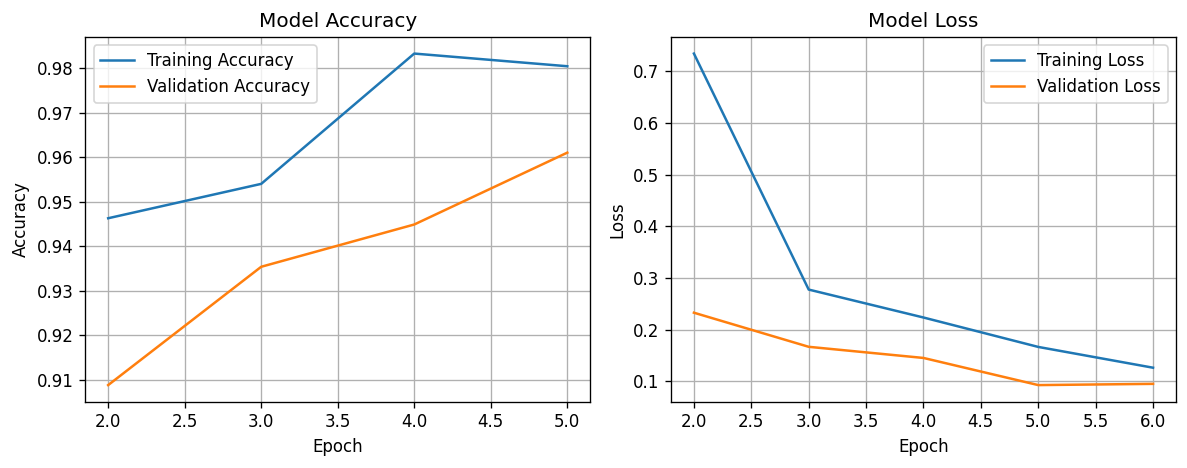

Using columns -> Train Acc: train/accuracy_top1 | Val Acc: metrics/accuracy_top1 | Train Loss: train/loss | Val Loss: val/loss


In [36]:
## Phase 4 — Training Visualizations (Accuracy/Loss, LR Schedule)

import pandas as pd
import re

# Find results.csv for this run
cands = sorted(glob.glob(f"{PROJECT}/{RUN_NAME}*/results.csv"), key=os.path.getmtime)
assert cands, "No results.csv found. Ensure training finished."
hist = pd.read_csv(cands[-1])
print("results.csv columns:", hist.columns.tolist())

# ---------- Fuzzy column picker (case-insensitive, substring allowed) ----------
def pick_one(candidates, df_cols):
    """Return first matching column from candidates (by exact or substring, case-insensitive)."""
    cols_lower = {c.lower(): c for c in df_cols}
    # exact, case-insensitive
    for cand in candidates:
        if cand.lower() in cols_lower:
            return cols_lower[cand.lower()]
    # substring, case-insensitive
    for cand in candidates:
        pat = re.compile(re.escape(cand), re.IGNORECASE)
        for c in df_cols:
            if pat.search(c):
                return c
    return None


# --- STRICT column mapping so train != val ---
train_acc_candidates = [
    "train/accuracy_top1", "train/acc", "train_accuracy", "train/accuracy"
]
val_acc_candidates = [
    "metrics/accuracy_top1",  # <- Ultralytics val acc
    "val/metrics/accuracy_top1","val/acc","val_accuracy","val/accuracy_top1",
    "val/metrics/accuracy","metrics/val_accuracy","validation_accuracy","valid/acc"
]

train_loss_candidates = ["train/loss","train_loss","train/cls_loss","metrics/train/loss","loss"]
val_loss_candidates   = ["val/loss","val/loss_epoch","val_loss","valid/loss","validation_loss"]

acc_tr_col = pick_one(train_acc_candidates, hist.columns)
acc_va_col = pick_one(val_acc_candidates,   hist.columns)
loss_tr_col= pick_one(train_loss_candidates, hist.columns)
loss_va_col= pick_one(val_loss_candidates,   hist.columns)

# Safety: ensure train != val accuracy column
if acc_tr_col == acc_va_col:
    for cand in val_acc_candidates:
        if cand in hist.columns and cand != acc_tr_col:
            acc_va_col = cand
            break

# Build epoch index and drop epochs with NaN train accuracy (first epoch may miss)
epochs = hist["epoch"] + 1 if "epoch" in hist.columns else np.arange(1, len(hist)+1)
plot_df = hist.copy()
if acc_tr_col in plot_df.columns:
    mask = ~plot_df[acc_tr_col].isna()
    if mask.any():
        plot_df = plot_df.loc[mask]
        epochs  = (plot_df["epoch"] + 1) if "epoch" in plot_df.columns else np.arange(1, len(plot_df)+1)

# ---------- Accuracy & Loss plots ----------
fig = plt.figure(figsize=(10,4))

# Accuracy plot
ax1 = plt.subplot(1,2,1)
plotted_any = False
if acc_tr_col is not None and acc_tr_col in plot_df.columns:
    ax1.plot(epochs, plot_df[acc_tr_col], label="Training Accuracy")
    plotted_any = True
if acc_va_col is not None and acc_va_col in plot_df.columns:
    ax1.plot(epochs, plot_df[acc_va_col], label="Validation Accuracy")
    plotted_any = True
if not plotted_any:
    ax1.text(0.1,0.5,"No accuracy columns found in results.csv", transform=ax1.transAxes)
ax1.set_title("Model Accuracy")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy")
if plotted_any: ax1.legend()

# Loss plot
ax2 = plt.subplot(1,2,2)
plotted_any = False
if loss_tr_col is not None and loss_tr_col in hist.columns:
    ax2.plot(hist["epoch"]+1, hist[loss_tr_col], label="Training Loss")
    plotted_any = True
if loss_va_col is not None and loss_va_col in hist.columns:
    ax2.plot(hist["epoch"]+1, hist[loss_va_col], label="Validation Loss")
    plotted_any = True
if not plotted_any:
    ax2.text(0.1,0.5,"No loss columns found in results.csv", transform=ax2.transAxes)
ax2.set_title("Model Loss")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Loss")
if plotted_any: ax2.legend()

fig.tight_layout()
plt.show()

print("Using columns ->",
      "Train Acc:", acc_tr_col,
      "| Val Acc:", acc_va_col,
      "| Train Loss:", loss_tr_col,
      "| Val Loss:", loss_va_col)


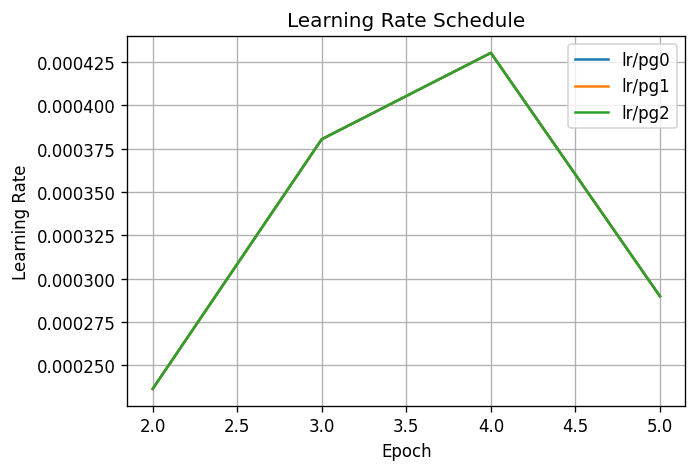

In [35]:
# Learning-rate schedule
lr_cols = [c for c in hist.columns if c.lower().startswith("lr") or c.startswith("lr/")]
if lr_cols:
    plt.figure()
    # Use the filtered plot_df and epochs for consistency
    for c in lr_cols:
        if c in plot_df.columns: # Ensure the column exists in the filtered df
             plt.plot(epochs, plot_df[c], label=c)
    plt.title("Learning Rate Schedule")
    plt.xlabel("Epoch"); plt.ylabel("Learning Rate")
    plt.legend()
    plt.show()
else:
    print("No LR columns found in results.csv")

## Phase 5 — Evaluation & Metrics (Confusion Matrix, Per-Class Bars, Report)

Ultralytics 8.3.40 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
train: /content/drive/MyDrive/DL_Project_SPLIT/train... found 4914 images in 4 classes ✅ 
val: /content/drive/MyDrive/DL_Project_SPLIT/val... found 1052 images in 4 classes ✅ 
test: /content/drive/MyDrive/DL_Project_SPLIT/test... found 1057 images in 4 classes ✅ 


val: Scanning /content/drive/MyDrive/DL_Project_SPLIT/val... 1052 images, 0 corrupt: 100%|██████████| 1052/1052 [00:00<?, ?it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 33/33 [00:09<00:00,  3.44it/s]


                   all      0.969          1
Speed: 0.1ms preprocess, 0.5ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/bt_yolo11n_assignment24
Validation metrics: {'metrics/accuracy_top1': 0.9686312079429626, 'metrics/accuracy_top5': 1.0, 'fitness': 0.9843156039714813}
Predicting on images in: /content/drive/MyDrive/DL_Project_SPLIT/test/glioma
Predicting on images in: /content/drive/MyDrive/DL_Project_SPLIT/test/meningioma
Predicting on images in: /content/drive/MyDrive/DL_Project_SPLIT/test/pituitary
Predicting on images in: /content/drive/MyDrive/DL_Project_SPLIT/test/notumor


<Figure size 600x600 with 0 Axes>

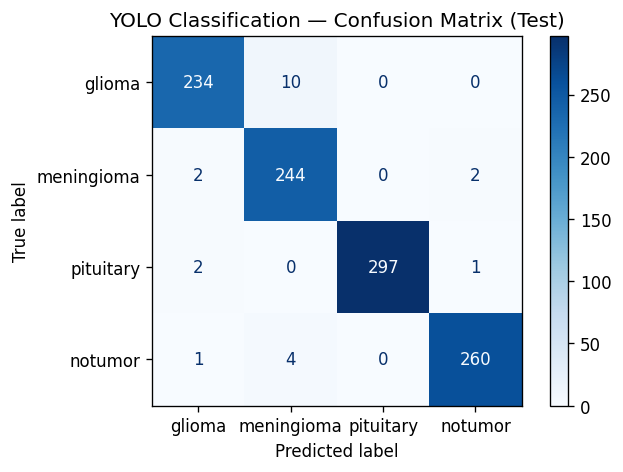

Confusion Matrix raw:
 [[234  10   0   0]
 [  2 244   0   2]
 [  2   0 297   1]
 [  1   4   0 260]]
Per-class accuracy: {'glioma': np.float64(0.9590163934426229), 'meningioma': np.float64(0.9838709677419355), 'pituitary': np.float64(0.99), 'notumor': np.float64(0.9811320754716981)}


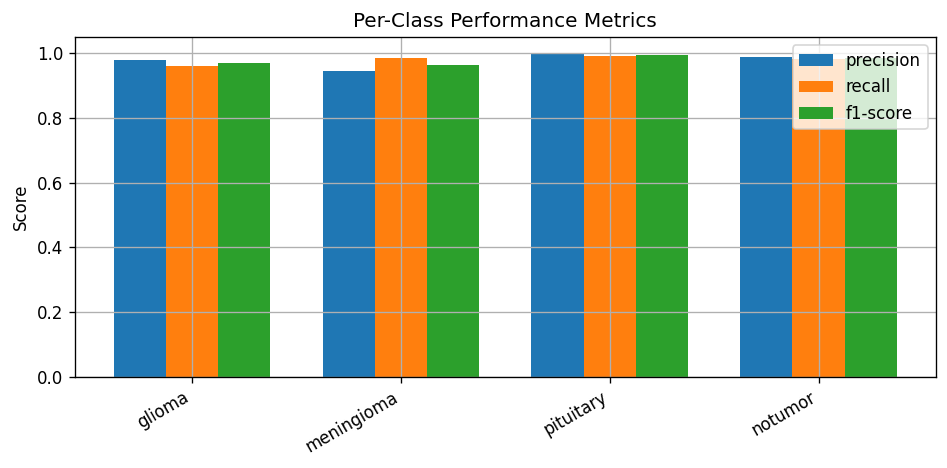

,precision,recall,f1-score,support
glioma,0.979079,0.959016,0.968944,244.000000
meningioma,0.945736,0.983871,0.964427,248.000000
pituitary,1.000000,0.990000,0.994975,300.000000
notumor,0.988593,0.981132,0.984848,265.000000
accuracy,0.979186,0.979186,0.979186,0.979186
macro avg,0.978352,0.978505,0.978299,1057.000000
weighted avg,0.979579,0.979186,0.979260,1057.000000


In [39]:
# Validate and predict on TEST set to build confusion matrix and metrics
IMG_SIZE = 224
BATCH = 32

# Quick val summary
val_results = model.val(split="val", imgsz=IMG_SIZE, batch=BATCH)
print("Validation metrics:", getattr(val_results, "results_dict", None))

# Predict on test set by iterating through class subdirectories
pred_list = []
# Map class names
y_true, y_pred = [], []
# Ultralytics model.names is a dict {index: name}
names = list(model.names.values())
idx_map = {name:i for i,name in enumerate(names)}

# Iterate through each class directory within the test split
for cls in classes:
    class_test_dir = Path(TEST_DIR) / cls
    if class_test_dir.exists() and any(class_test_dir.iterdir()): # Check if directory exists and is not empty
        print(f"Predicting on images in: {class_test_dir}")
        class_pred_list = model.predict(source=str(class_test_dir), imgsz=IMG_SIZE, stream=False, save=False, verbose=False)
        pred_list.extend(class_pred_list)

        # Collect true and predicted labels for this class
        true_idx = idx_map.get(cls, None)
        if true_idx is None:
            # fallback: use our classes list index
            if cls in classes:
                true_idx = classes.index(cls)
            else:
                continue # Skip if class name not found

        for r in class_pred_list:
             y_true.append(true_idx)
             y_pred.append(int(r.probs.top1))
    else:
        print(f"Skipping empty or non-existent directory: {class_test_dir}")


if not pred_list:
    print("No predictions were made. Check if test directories contain images.")

# Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes) # Used 'classes' instead of 'test_classes'

plt.figure(figsize=(5,5))
disp.plot(cmap='Blues', values_format='d')
plt.title('YOLO Classification — Confusion Matrix (Test)')
plt.grid(False)
plt.show()

print("Confusion Matrix raw:\n", cm)
print("Per-class accuracy:",
      {cls: cm[i,i]/cm[i].sum() if cm[i].sum() else 0.0 for i, cls in enumerate(classes)}) # Used 'classes'

# Per-class Precision/Recall/F1
report = classification_report(y_true, y_pred, target_names=classes, output_dict=True, zero_division=0)
import pandas as pd
df_rep = pd.DataFrame(report).T

# Bars for per-class metrics
metrics = ["precision","recall","f1-score"]
x = np.arange(len(classes))
plt.figure(figsize=(8,4))
for i,m in enumerate(metrics):
    plt.bar(x + i*0.25, [report[c][m] for c in classes], width=0.25, label=m)
plt.xticks(x + 0.25, classes, rotation=30, ha="right")
plt.ylabel("Score"); plt.title("Per-Class Performance Metrics")
plt.legend()
plt.tight_layout()
plt.show()

# Table view
display(df_rep.loc[classes + ["accuracy","macro avg","weighted avg"], ["precision","recall","f1-score","support"]])

# Train YOLOv11n (Classification Mode) 30 Epoch

In [40]:
MODEL_NAME = "yolo11n-cls.pt"
EPOCHS = 30
IMG_SIZE = 224
BATCH = 32
PATIENCE = 20
PROJECT = "runs/classify"
RUN_NAME = "bt_yolo11n_assignment"

model = YOLO(MODEL_NAME)
model.add_callback("on_fit_epoch_end", on_fit_epoch_end)

train_results = model.train(
    data=str(SPLIT_ROOT),
    epochs=EPOCHS,
    imgsz=IMG_SIZE,
    batch=BATCH,
    patience=PATIENCE,
    project=PROJECT,
    name=RUN_NAME,
    verbose=True
)
print("Training directory:", getattr(train_results, "save_dir", None) or "runs/classify/...")

New https://pypi.org/project/ultralytics/8.3.221 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.40 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=classify, mode=train, model=yolo11n-cls.pt, data=/content/drive/MyDrive/DL_Project_SPLIT, epochs=30, time=None, patience=20, batch=32, imgsz=224, save=True, save_period=-1, cache=False, device=None, workers=8, project=runs/classify, name=bt_yolo11n_assignment3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_mask

train: Scanning /content/drive/MyDrive/DL_Project_SPLIT/train... 4914 images, 0 corrupt: 100%|██████████| 4914/4914 [00:00<?, ?it/s]
val: Scanning /content/drive/MyDrive/DL_Project_SPLIT/val... 1052 images, 0 corrupt: 100%|██████████| 1052/1052 [00:00<?, ?it/s]


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 39 weight(decay=0.0), 40 weight(decay=0.0005), 40 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 224 train, 224 val
Using 2 dataloader workers
Logging results to runs/classify/bt_yolo11n_assignment3
Starting training for 30 epochs...

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:07<00:00,  2.36it/s]

                   all      0.909          1


Ultralytics 8.3.40 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n-cls summary (fused): 112 layers, 1,531,148 parameters, 0 gradients, 3.2 GFLOPs
train: /content/drive/MyDrive/DL_Project_SPLIT/train... found 4914 images in 4 classes ✅ 
val: /content/drive/MyDrive/DL_Project_SPLIT/val... found 1052 images in 4 classes ✅ 
test: /content/drive/MyDrive/DL_Project_SPLIT/test... found 1057 images in 4 classes ✅ 


train: Scanning /content/drive/MyDrive/DL_Project_SPLIT/train... 4914 images, 0 corrupt: 100%|██████████| 4914/4914 [00:00<?, ?it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 154/154 [00:44<00:00,  3.48it/s]

                   all      0.928          1
Speed: 0.1ms preprocess, 0.4ms inference, 0.0ms loss, 0.0ms postprocess per image



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:07<00:00,  2.31it/s]

                   all      0.921          1


Ultralytics 8.3.40 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n-cls summary (fused): 112 layers, 1,531,148 parameters, 0 gradients, 3.2 GFLOPs
train: /content/drive/MyDrive/DL_Project_SPLIT/train... found 4914 images in 4 classes ✅ 
val: /content/drive/MyDrive/DL_Project_SPLIT/val... found 1052 images in 4 classes ✅ 
test: /content/drive/MyDrive/DL_Project_SPLIT/test... found 1057 images in 4 classes ✅ 


train: Scanning /content/drive/MyDrive/DL_Project_SPLIT/train... 4914 images, 0 corrupt: 100%|██████████| 4914/4914 [00:00<?, ?it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 154/154 [00:43<00:00,  3.52it/s]

                   all      0.939          1
Speed: 0.1ms preprocess, 0.4ms inference, 0.0ms loss, 0.0ms postprocess per image



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:07<00:00,  2.30it/s]

                   all      0.928          1


Ultralytics 8.3.40 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n-cls summary (fused): 112 layers, 1,531,148 parameters, 0 gradients, 3.2 GFLOPs
train: /content/drive/MyDrive/DL_Project_SPLIT/train... found 4914 images in 4 classes ✅ 
val: /content/drive/MyDrive/DL_Project_SPLIT/val... found 1052 images in 4 classes ✅ 
test: /content/drive/MyDrive/DL_Project_SPLIT/test... found 1057 images in 4 classes ✅ 


train: Scanning /content/drive/MyDrive/DL_Project_SPLIT/train... 4914 images, 0 corrupt: 100%|██████████| 4914/4914 [00:00<?, ?it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 154/154 [00:43<00:00,  3.52it/s]

                   all      0.938          1
Speed: 0.1ms preprocess, 0.4ms inference, 0.0ms loss, 0.0ms postprocess per image



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:08<00:00,  1.98it/s]

                   all      0.948          1


Ultralytics 8.3.40 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n-cls summary (fused): 112 layers, 1,531,148 parameters, 0 gradients, 3.2 GFLOPs
train: /content/drive/MyDrive/DL_Project_SPLIT/train... found 4914 images in 4 classes ✅ 
val: /content/drive/MyDrive/DL_Project_SPLIT/val... found 1052 images in 4 classes ✅ 
test: /content/drive/MyDrive/DL_Project_SPLIT/test... found 1057 images in 4 classes ✅ 


train: Scanning /content/drive/MyDrive/DL_Project_SPLIT/train... 4914 images, 0 corrupt: 100%|██████████| 4914/4914 [00:00<?, ?it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 154/154 [00:43<00:00,  3.55it/s]

                   all      0.958          1
Speed: 0.1ms preprocess, 0.5ms inference, 0.0ms loss, 0.0ms postprocess per image



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:08<00:00,  2.03it/s]

                   all      0.946          1


Ultralytics 8.3.40 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n-cls summary (fused): 112 layers, 1,531,148 parameters, 0 gradients, 3.2 GFLOPs
train: /content/drive/MyDrive/DL_Project_SPLIT/train... found 4914 images in 4 classes ✅ 
val: /content/drive/MyDrive/DL_Project_SPLIT/val... found 1052 images in 4 classes ✅ 
test: /content/drive/MyDrive/DL_Project_SPLIT/test... found 1057 images in 4 classes ✅ 


train: Scanning /content/drive/MyDrive/DL_Project_SPLIT/train... 4914 images, 0 corrupt: 100%|██████████| 4914/4914 [00:00<?, ?it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 154/154 [00:50<00:00,  3.06it/s]

                   all      0.961          1
Speed: 0.1ms preprocess, 0.5ms inference, 0.0ms loss, 0.0ms postprocess per image



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:07<00:00,  2.35it/s]

                   all      0.966          1


Ultralytics 8.3.40 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n-cls summary (fused): 112 layers, 1,531,148 parameters, 0 gradients, 3.2 GFLOPs
train: /content/drive/MyDrive/DL_Project_SPLIT/train... found 4914 images in 4 classes ✅ 
val: /content/drive/MyDrive/DL_Project_SPLIT/val... found 1052 images in 4 classes ✅ 
test: /content/drive/MyDrive/DL_Project_SPLIT/test... found 1057 images in 4 classes ✅ 


train: Scanning /content/drive/MyDrive/DL_Project_SPLIT/train... 4914 images, 0 corrupt: 100%|██████████| 4914/4914 [00:00<?, ?it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 154/154 [00:44<00:00,  3.48it/s]

                   all      0.977          1
Speed: 0.1ms preprocess, 0.5ms inference, 0.0ms loss, 0.0ms postprocess per image



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:07<00:00,  2.35it/s]

                   all      0.969          1


Ultralytics 8.3.40 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n-cls summary (fused): 112 layers, 1,531,148 parameters, 0 gradients, 3.2 GFLOPs
train: /content/drive/MyDrive/DL_Project_SPLIT/train... found 4914 images in 4 classes ✅ 
val: /content/drive/MyDrive/DL_Project_SPLIT/val... found 1052 images in 4 classes ✅ 
test: /content/drive/MyDrive/DL_Project_SPLIT/test... found 1057 images in 4 classes ✅ 


train: Scanning /content/drive/MyDrive/DL_Project_SPLIT/train... 4914 images, 0 corrupt: 100%|██████████| 4914/4914 [00:00<?, ?it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 154/154 [00:50<00:00,  3.07it/s]

                   all      0.984          1
Speed: 0.1ms preprocess, 0.5ms inference, 0.0ms loss, 0.0ms postprocess per image



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:08<00:00,  2.01it/s]

                   all      0.959          1


Ultralytics 8.3.40 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n-cls summary (fused): 112 layers, 1,531,148 parameters, 0 gradients, 3.2 GFLOPs
train: /content/drive/MyDrive/DL_Project_SPLIT/train... found 4914 images in 4 classes ✅ 
val: /content/drive/MyDrive/DL_Project_SPLIT/val... found 1052 images in 4 classes ✅ 
test: /content/drive/MyDrive/DL_Project_SPLIT/test... found 1057 images in 4 classes ✅ 


train: Scanning /content/drive/MyDrive/DL_Project_SPLIT/train... 4914 images, 0 corrupt: 100%|██████████| 4914/4914 [00:00<?, ?it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 154/154 [00:43<00:00,  3.52it/s]

                   all      0.978          1
Speed: 0.1ms preprocess, 0.5ms inference, 0.0ms loss, 0.0ms postprocess per image



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:08<00:00,  1.93it/s]

                   all      0.971          1


Ultralytics 8.3.40 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n-cls summary (fused): 112 layers, 1,531,148 parameters, 0 gradients, 3.2 GFLOPs
train: /content/drive/MyDrive/DL_Project_SPLIT/train... found 4914 images in 4 classes ✅ 
val: /content/drive/MyDrive/DL_Project_SPLIT/val... found 1052 images in 4 classes ✅ 
test: /content/drive/MyDrive/DL_Project_SPLIT/test... found 1057 images in 4 classes ✅ 


train: Scanning /content/drive/MyDrive/DL_Project_SPLIT/train... 4914 images, 0 corrupt: 100%|██████████| 4914/4914 [00:00<?, ?it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 154/154 [00:49<00:00,  3.09it/s]

                   all      0.988          1
Speed: 0.1ms preprocess, 0.5ms inference, 0.0ms loss, 0.0ms postprocess per image



      Epoch    GPU_mem       loss  Instances       Size


      10/30      0.47G     0.1152         18        224: 100%|██████████| 154/154 [00:54<00:00,  2.82it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:07<00:00,  2.18it/s]

                   all      0.972          1


Ultralytics 8.3.40 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n-cls summary (fused): 112 layers, 1,531,148 parameters, 0 gradients, 3.2 GFLOPs
train: /content/drive/MyDrive/DL_Project_SPLIT/train... found 4914 images in 4 classes ✅ 
val: /content/drive/MyDrive/DL_Project_SPLIT/val... found 1052 images in 4 classes ✅ 
test: /content/drive/MyDrive/DL_Project_SPLIT/test... found 1057 images in 4 classes ✅ 


train: Scanning /content/drive/MyDrive/DL_Project_SPLIT/train... 4914 images, 0 corrupt: 100%|██████████| 4914/4914 [00:00<?, ?it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 154/154 [00:43<00:00,  3.55it/s]

                   all      0.991          1
Speed: 0.1ms preprocess, 0.5ms inference, 0.0ms loss, 0.0ms postprocess per image



      Epoch    GPU_mem       loss  Instances       Size


      11/30      0.47G     0.1007         18        224: 100%|██████████| 154/154 [00:54<00:00,  2.82it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:08<00:00,  1.94it/s]

                   all      0.971          1


Ultralytics 8.3.40 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n-cls summary (fused): 112 layers, 1,531,148 parameters, 0 gradients, 3.2 GFLOPs
train: /content/drive/MyDrive/DL_Project_SPLIT/train... found 4914 images in 4 classes ✅ 
val: /content/drive/MyDrive/DL_Project_SPLIT/val... found 1052 images in 4 classes ✅ 
test: /content/drive/MyDrive/DL_Project_SPLIT/test... found 1057 images in 4 classes ✅ 


train: Scanning /content/drive/MyDrive/DL_Project_SPLIT/train... 4914 images, 0 corrupt: 100%|██████████| 4914/4914 [00:00<?, ?it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 154/154 [00:43<00:00,  3.57it/s]

                   all      0.989          1
Speed: 0.1ms preprocess, 0.4ms inference, 0.0ms loss, 0.0ms postprocess per image



      Epoch    GPU_mem       loss  Instances       Size


      12/30      0.47G     0.1011         18        224: 100%|██████████| 154/154 [00:54<00:00,  2.83it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:08<00:00,  1.93it/s]

                   all      0.972          1


Ultralytics 8.3.40 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n-cls summary (fused): 112 layers, 1,531,148 parameters, 0 gradients, 3.2 GFLOPs
train: /content/drive/MyDrive/DL_Project_SPLIT/train... found 4914 images in 4 classes ✅ 
val: /content/drive/MyDrive/DL_Project_SPLIT/val... found 1052 images in 4 classes ✅ 
test: /content/drive/MyDrive/DL_Project_SPLIT/test... found 1057 images in 4 classes ✅ 


train: Scanning /content/drive/MyDrive/DL_Project_SPLIT/train... 4914 images, 0 corrupt: 100%|██████████| 4914/4914 [00:00<?, ?it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 154/154 [00:43<00:00,  3.51it/s]

                   all      0.992          1
Speed: 0.1ms preprocess, 0.5ms inference, 0.0ms loss, 0.0ms postprocess per image



      Epoch    GPU_mem       loss  Instances       Size


      13/30      0.47G    0.08808         18        224: 100%|██████████| 154/154 [00:54<00:00,  2.83it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:08<00:00,  1.96it/s]

                   all       0.97          1


Ultralytics 8.3.40 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n-cls summary (fused): 112 layers, 1,531,148 parameters, 0 gradients, 3.2 GFLOPs
train: /content/drive/MyDrive/DL_Project_SPLIT/train... found 4914 images in 4 classes ✅ 
val: /content/drive/MyDrive/DL_Project_SPLIT/val... found 1052 images in 4 classes ✅ 
test: /content/drive/MyDrive/DL_Project_SPLIT/test... found 1057 images in 4 classes ✅ 


train: Scanning /content/drive/MyDrive/DL_Project_SPLIT/train... 4914 images, 0 corrupt: 100%|██████████| 4914/4914 [00:00<?, ?it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 154/154 [00:43<00:00,  3.53it/s]

                   all      0.991          1
Speed: 0.1ms preprocess, 0.5ms inference, 0.0ms loss, 0.0ms postprocess per image



      Epoch    GPU_mem       loss  Instances       Size


      14/30      0.47G     0.1019         18        224: 100%|██████████| 154/154 [00:54<00:00,  2.82it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:08<00:00,  2.04it/s]

                   all      0.979          1


Ultralytics 8.3.40 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n-cls summary (fused): 112 layers, 1,531,148 parameters, 0 gradients, 3.2 GFLOPs
train: /content/drive/MyDrive/DL_Project_SPLIT/train... found 4914 images in 4 classes ✅ 
val: /content/drive/MyDrive/DL_Project_SPLIT/val... found 1052 images in 4 classes ✅ 
test: /content/drive/MyDrive/DL_Project_SPLIT/test... found 1057 images in 4 classes ✅ 


train: Scanning /content/drive/MyDrive/DL_Project_SPLIT/train... 4914 images, 0 corrupt: 100%|██████████| 4914/4914 [00:00<?, ?it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 154/154 [00:43<00:00,  3.56it/s]

                   all      0.996          1
Speed: 0.1ms preprocess, 0.5ms inference, 0.0ms loss, 0.0ms postprocess per image



      Epoch    GPU_mem       loss  Instances       Size


      15/30     0.472G    0.07403         18        224: 100%|██████████| 154/154 [00:54<00:00,  2.82it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:08<00:00,  1.98it/s]

                   all      0.987          1


Ultralytics 8.3.40 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n-cls summary (fused): 112 layers, 1,531,148 parameters, 0 gradients, 3.2 GFLOPs
train: /content/drive/MyDrive/DL_Project_SPLIT/train... found 4914 images in 4 classes ✅ 
val: /content/drive/MyDrive/DL_Project_SPLIT/val... found 1052 images in 4 classes ✅ 
test: /content/drive/MyDrive/DL_Project_SPLIT/test... found 1057 images in 4 classes ✅ 


train: Scanning /content/drive/MyDrive/DL_Project_SPLIT/train... 4914 images, 0 corrupt: 100%|██████████| 4914/4914 [00:00<?, ?it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 154/154 [00:43<00:00,  3.56it/s]

                   all      0.993          1
Speed: 0.1ms preprocess, 0.4ms inference, 0.0ms loss, 0.0ms postprocess per image



      Epoch    GPU_mem       loss  Instances       Size


      16/30      0.47G    0.07547         18        224: 100%|██████████| 154/154 [00:54<00:00,  2.82it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:08<00:00,  2.03it/s]

                   all      0.982          1


Ultralytics 8.3.40 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n-cls summary (fused): 112 layers, 1,531,148 parameters, 0 gradients, 3.2 GFLOPs
train: /content/drive/MyDrive/DL_Project_SPLIT/train... found 4914 images in 4 classes ✅ 
val: /content/drive/MyDrive/DL_Project_SPLIT/val... found 1052 images in 4 classes ✅ 
test: /content/drive/MyDrive/DL_Project_SPLIT/test... found 1057 images in 4 classes ✅ 


train: Scanning /content/drive/MyDrive/DL_Project_SPLIT/train... 4914 images, 0 corrupt: 100%|██████████| 4914/4914 [00:00<?, ?it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 154/154 [00:43<00:00,  3.58it/s]

                   all      0.991          1
Speed: 0.1ms preprocess, 0.4ms inference, 0.0ms loss, 0.0ms postprocess per image



      Epoch    GPU_mem       loss  Instances       Size


      17/30      0.47G    0.07079         18        224: 100%|██████████| 154/154 [00:54<00:00,  2.83it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:08<00:00,  2.07it/s]

                   all      0.984          1


Ultralytics 8.3.40 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n-cls summary (fused): 112 layers, 1,531,148 parameters, 0 gradients, 3.2 GFLOPs
train: /content/drive/MyDrive/DL_Project_SPLIT/train... found 4914 images in 4 classes ✅ 
val: /content/drive/MyDrive/DL_Project_SPLIT/val... found 1052 images in 4 classes ✅ 
test: /content/drive/MyDrive/DL_Project_SPLIT/test... found 1057 images in 4 classes ✅ 


train: Scanning /content/drive/MyDrive/DL_Project_SPLIT/train... 4914 images, 0 corrupt: 100%|██████████| 4914/4914 [00:00<?, ?it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 154/154 [00:43<00:00,  3.55it/s]

                   all      0.996          1
Speed: 0.1ms preprocess, 0.4ms inference, 0.0ms loss, 0.0ms postprocess per image



      Epoch    GPU_mem       loss  Instances       Size


      18/30      0.47G    0.07233         18        224: 100%|██████████| 154/154 [00:54<00:00,  2.82it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:08<00:00,  1.97it/s]

                   all      0.983          1


Ultralytics 8.3.40 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n-cls summary (fused): 112 layers, 1,531,148 parameters, 0 gradients, 3.2 GFLOPs
train: /content/drive/MyDrive/DL_Project_SPLIT/train... found 4914 images in 4 classes ✅ 
val: /content/drive/MyDrive/DL_Project_SPLIT/val... found 1052 images in 4 classes ✅ 
test: /content/drive/MyDrive/DL_Project_SPLIT/test... found 1057 images in 4 classes ✅ 


train: Scanning /content/drive/MyDrive/DL_Project_SPLIT/train... 4914 images, 0 corrupt: 100%|██████████| 4914/4914 [00:00<?, ?it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 154/154 [00:43<00:00,  3.55it/s]

                   all      0.995          1
Speed: 0.1ms preprocess, 0.5ms inference, 0.0ms loss, 0.0ms postprocess per image



      Epoch    GPU_mem       loss  Instances       Size


      19/30      0.47G    0.06484         18        224: 100%|██████████| 154/154 [00:53<00:00,  2.85it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:08<00:00,  2.01it/s]

                   all      0.986          1


Ultralytics 8.3.40 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n-cls summary (fused): 112 layers, 1,531,148 parameters, 0 gradients, 3.2 GFLOPs
train: /content/drive/MyDrive/DL_Project_SPLIT/train... found 4914 images in 4 classes ✅ 
val: /content/drive/MyDrive/DL_Project_SPLIT/val... found 1052 images in 4 classes ✅ 
test: /content/drive/MyDrive/DL_Project_SPLIT/test... found 1057 images in 4 classes ✅ 


train: Scanning /content/drive/MyDrive/DL_Project_SPLIT/train... 4914 images, 0 corrupt: 100%|██████████| 4914/4914 [00:00<?, ?it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 154/154 [00:44<00:00,  3.43it/s]

                   all      0.996          1
Speed: 0.1ms preprocess, 0.5ms inference, 0.0ms loss, 0.0ms postprocess per image



      Epoch    GPU_mem       loss  Instances       Size


      20/30      0.47G    0.05812         18        224: 100%|██████████| 154/154 [00:54<00:00,  2.84it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:07<00:00,  2.19it/s]

                   all      0.988          1


Ultralytics 8.3.40 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n-cls summary (fused): 112 layers, 1,531,148 parameters, 0 gradients, 3.2 GFLOPs
train: /content/drive/MyDrive/DL_Project_SPLIT/train... found 4914 images in 4 classes ✅ 
val: /content/drive/MyDrive/DL_Project_SPLIT/val... found 1052 images in 4 classes ✅ 
test: /content/drive/MyDrive/DL_Project_SPLIT/test... found 1057 images in 4 classes ✅ 


train: Scanning /content/drive/MyDrive/DL_Project_SPLIT/train... 4914 images, 0 corrupt: 100%|██████████| 4914/4914 [00:00<?, ?it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 154/154 [00:44<00:00,  3.49it/s]

                   all      0.997          1
Speed: 0.1ms preprocess, 0.4ms inference, 0.0ms loss, 0.0ms postprocess per image



      Epoch    GPU_mem       loss  Instances       Size


      21/30      0.47G    0.05077         18        224: 100%|██████████| 154/154 [00:55<00:00,  2.77it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:07<00:00,  2.30it/s]

                   all      0.985          1


Ultralytics 8.3.40 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n-cls summary (fused): 112 layers, 1,531,148 parameters, 0 gradients, 3.2 GFLOPs
train: /content/drive/MyDrive/DL_Project_SPLIT/train... found 4914 images in 4 classes ✅ 
val: /content/drive/MyDrive/DL_Project_SPLIT/val... found 1052 images in 4 classes ✅ 
test: /content/drive/MyDrive/DL_Project_SPLIT/test... found 1057 images in 4 classes ✅ 


train: Scanning /content/drive/MyDrive/DL_Project_SPLIT/train... 4914 images, 0 corrupt: 100%|██████████| 4914/4914 [00:00<?, ?it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 154/154 [00:43<00:00,  3.53it/s]

                   all      0.996          1
Speed: 0.1ms preprocess, 0.5ms inference, 0.0ms loss, 0.0ms postprocess per image



      Epoch    GPU_mem       loss  Instances       Size


      22/30      0.47G    0.04948         18        224: 100%|██████████| 154/154 [00:54<00:00,  2.82it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:07<00:00,  2.35it/s]

                   all      0.987          1


Ultralytics 8.3.40 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n-cls summary (fused): 112 layers, 1,531,148 parameters, 0 gradients, 3.2 GFLOPs
train: /content/drive/MyDrive/DL_Project_SPLIT/train... found 4914 images in 4 classes ✅ 
val: /content/drive/MyDrive/DL_Project_SPLIT/val... found 1052 images in 4 classes ✅ 
test: /content/drive/MyDrive/DL_Project_SPLIT/test... found 1057 images in 4 classes ✅ 


train: Scanning /content/drive/MyDrive/DL_Project_SPLIT/train... 4914 images, 0 corrupt: 100%|██████████| 4914/4914 [00:00<?, ?it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 154/154 [00:43<00:00,  3.53it/s]

                   all      0.998          1
Speed: 0.1ms preprocess, 0.5ms inference, 0.0ms loss, 0.0ms postprocess per image



      Epoch    GPU_mem       loss  Instances       Size


      23/30      0.47G    0.04487         18        224: 100%|██████████| 154/154 [00:54<00:00,  2.84it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:07<00:00,  2.35it/s]

                   all      0.986          1


Ultralytics 8.3.40 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n-cls summary (fused): 112 layers, 1,531,148 parameters, 0 gradients, 3.2 GFLOPs
train: /content/drive/MyDrive/DL_Project_SPLIT/train... found 4914 images in 4 classes ✅ 
val: /content/drive/MyDrive/DL_Project_SPLIT/val... found 1052 images in 4 classes ✅ 
test: /content/drive/MyDrive/DL_Project_SPLIT/test... found 1057 images in 4 classes ✅ 


train: Scanning /content/drive/MyDrive/DL_Project_SPLIT/train... 4914 images, 0 corrupt: 100%|██████████| 4914/4914 [00:00<?, ?it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 154/154 [00:43<00:00,  3.53it/s]

                   all      0.998          1
Speed: 0.1ms preprocess, 0.5ms inference, 0.0ms loss, 0.0ms postprocess per image



      Epoch    GPU_mem       loss  Instances       Size


      24/30      0.47G    0.04832         18        224: 100%|██████████| 154/154 [00:54<00:00,  2.84it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:07<00:00,  2.24it/s]

                   all      0.983          1


Ultralytics 8.3.40 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n-cls summary (fused): 112 layers, 1,531,148 parameters, 0 gradients, 3.2 GFLOPs
train: /content/drive/MyDrive/DL_Project_SPLIT/train... found 4914 images in 4 classes ✅ 
val: /content/drive/MyDrive/DL_Project_SPLIT/val... found 1052 images in 4 classes ✅ 
test: /content/drive/MyDrive/DL_Project_SPLIT/test... found 1057 images in 4 classes ✅ 


train: Scanning /content/drive/MyDrive/DL_Project_SPLIT/train... 4914 images, 0 corrupt: 100%|██████████| 4914/4914 [00:00<?, ?it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 154/154 [00:43<00:00,  3.53it/s]

                   all      0.998          1
Speed: 0.1ms preprocess, 0.4ms inference, 0.0ms loss, 0.0ms postprocess per image



      Epoch    GPU_mem       loss  Instances       Size


      25/30      0.47G    0.04319         18        224: 100%|██████████| 154/154 [00:54<00:00,  2.82it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:08<00:00,  2.04it/s]

                   all      0.984          1


Ultralytics 8.3.40 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n-cls summary (fused): 112 layers, 1,531,148 parameters, 0 gradients, 3.2 GFLOPs
train: /content/drive/MyDrive/DL_Project_SPLIT/train... found 4914 images in 4 classes ✅ 
val: /content/drive/MyDrive/DL_Project_SPLIT/val... found 1052 images in 4 classes ✅ 
test: /content/drive/MyDrive/DL_Project_SPLIT/test... found 1057 images in 4 classes ✅ 


train: Scanning /content/drive/MyDrive/DL_Project_SPLIT/train... 4914 images, 0 corrupt: 100%|██████████| 4914/4914 [00:00<?, ?it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 154/154 [00:43<00:00,  3.54it/s]

                   all      0.999          1
Speed: 0.1ms preprocess, 0.5ms inference, 0.0ms loss, 0.0ms postprocess per image



      Epoch    GPU_mem       loss  Instances       Size


      26/30      0.47G    0.04717         18        224: 100%|██████████| 154/154 [00:54<00:00,  2.82it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:08<00:00,  1.99it/s]

                   all      0.987          1


Ultralytics 8.3.40 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n-cls summary (fused): 112 layers, 1,531,148 parameters, 0 gradients, 3.2 GFLOPs
train: /content/drive/MyDrive/DL_Project_SPLIT/train... found 4914 images in 4 classes ✅ 
val: /content/drive/MyDrive/DL_Project_SPLIT/val... found 1052 images in 4 classes ✅ 
test: /content/drive/MyDrive/DL_Project_SPLIT/test... found 1057 images in 4 classes ✅ 


train: Scanning /content/drive/MyDrive/DL_Project_SPLIT/train... 4914 images, 0 corrupt: 100%|██████████| 4914/4914 [00:00<?, ?it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 154/154 [00:43<00:00,  3.52it/s]

                   all      0.998          1
Speed: 0.1ms preprocess, 0.4ms inference, 0.0ms loss, 0.0ms postprocess per image



      Epoch    GPU_mem       loss  Instances       Size


      27/30      0.47G    0.03342         18        224: 100%|██████████| 154/154 [00:54<00:00,  2.82it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:08<00:00,  1.96it/s]

                   all      0.986          1


Ultralytics 8.3.40 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n-cls summary (fused): 112 layers, 1,531,148 parameters, 0 gradients, 3.2 GFLOPs
train: /content/drive/MyDrive/DL_Project_SPLIT/train... found 4914 images in 4 classes ✅ 
val: /content/drive/MyDrive/DL_Project_SPLIT/val... found 1052 images in 4 classes ✅ 
test: /content/drive/MyDrive/DL_Project_SPLIT/test... found 1057 images in 4 classes ✅ 


train: Scanning /content/drive/MyDrive/DL_Project_SPLIT/train... 4914 images, 0 corrupt: 100%|██████████| 4914/4914 [00:00<?, ?it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 154/154 [00:43<00:00,  3.52it/s]

                   all      0.999          1
Speed: 0.1ms preprocess, 0.5ms inference, 0.0ms loss, 0.0ms postprocess per image



      Epoch    GPU_mem       loss  Instances       Size


      28/30      0.47G    0.03449         18        224: 100%|██████████| 154/154 [00:54<00:00,  2.82it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:08<00:00,  1.98it/s]

                   all      0.986          1


Ultralytics 8.3.40 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n-cls summary (fused): 112 layers, 1,531,148 parameters, 0 gradients, 3.2 GFLOPs
train: /content/drive/MyDrive/DL_Project_SPLIT/train... found 4914 images in 4 classes ✅ 
val: /content/drive/MyDrive/DL_Project_SPLIT/val... found 1052 images in 4 classes ✅ 
test: /content/drive/MyDrive/DL_Project_SPLIT/test... found 1057 images in 4 classes ✅ 


train: Scanning /content/drive/MyDrive/DL_Project_SPLIT/train... 4914 images, 0 corrupt: 100%|██████████| 4914/4914 [00:00<?, ?it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 154/154 [00:43<00:00,  3.56it/s]

                   all      0.999          1
Speed: 0.1ms preprocess, 0.5ms inference, 0.0ms loss, 0.0ms postprocess per image



      Epoch    GPU_mem       loss  Instances       Size


      29/30      0.47G    0.03498         18        224: 100%|██████████| 154/154 [00:54<00:00,  2.83it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:08<00:00,  1.92it/s]

                   all      0.986          1


Ultralytics 8.3.40 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n-cls summary (fused): 112 layers, 1,531,148 parameters, 0 gradients, 3.2 GFLOPs
train: /content/drive/MyDrive/DL_Project_SPLIT/train... found 4914 images in 4 classes ✅ 
val: /content/drive/MyDrive/DL_Project_SPLIT/val... found 1052 images in 4 classes ✅ 
test: /content/drive/MyDrive/DL_Project_SPLIT/test... found 1057 images in 4 classes ✅ 


train: Scanning /content/drive/MyDrive/DL_Project_SPLIT/train... 4914 images, 0 corrupt: 100%|██████████| 4914/4914 [00:00<?, ?it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 154/154 [00:44<00:00,  3.47it/s]

                   all          1          1
Speed: 0.1ms preprocess, 0.5ms inference, 0.0ms loss, 0.0ms postprocess per image



      Epoch    GPU_mem       loss  Instances       Size


      30/30      0.47G    0.03763         18        224: 100%|██████████| 154/154 [00:54<00:00,  2.83it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:07<00:00,  2.21it/s]

                   all      0.986          1


Ultralytics 8.3.40 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n-cls summary (fused): 112 layers, 1,531,148 parameters, 0 gradients, 3.2 GFLOPs
train: /content/drive/MyDrive/DL_Project_SPLIT/train... found 4914 images in 4 classes ✅ 
val: /content/drive/MyDrive/DL_Project_SPLIT/val... found 1052 images in 4 classes ✅ 
test: /content/drive/MyDrive/DL_Project_SPLIT/test... found 1057 images in 4 classes ✅ 


train: Scanning /content/drive/MyDrive/DL_Project_SPLIT/train... 4914 images, 0 corrupt: 100%|██████████| 4914/4914 [00:00<?, ?it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 154/154 [00:44<00:00,  3.49it/s]

                   all          1          1
Speed: 0.1ms preprocess, 0.5ms inference, 0.0ms loss, 0.0ms postprocess per image



30 epochs completed in 0.941 hours.
Optimizer stripped from runs/classify/bt_yolo11n_assignment3/weights/last.pt, 3.2MB
Optimizer stripped from runs/classify/bt_yolo11n_assignment3/weights/best.pt, 3.2MB

Validating runs/classify/bt_yolo11n_assignment3/weights/best.pt...
Ultralytics 8.3.40 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n-cls summary (fused): 112 layers, 1,531,148 parameters, 0 gradients, 3.2 GFLOPs
train: /content/drive/MyDrive/DL_Project_SPLIT/train... found 4914 images in 4 classes ✅ 
val: /content/drive/MyDrive/DL_Project_SPLIT/val... found 1052 images in 4 classes ✅ 
test: /content/drive/MyDrive/DL_Project_SPLIT/test... found 1057 images in 4 classes ✅ 


               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:07<00:00,  2.30it/s]


                   all      0.988          1
Speed: 0.1ms preprocess, 0.4ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/bt_yolo11n_assignment3
Ultralytics 8.3.40 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n-cls summary (fused): 112 layers, 1,531,148 parameters, 0 gradients, 3.2 GFLOPs
train: /content/drive/MyDrive/DL_Project_SPLIT/train... found 4914 images in 4 classes ✅ 
val: /content/drive/MyDrive/DL_Project_SPLIT/val... found 1052 images in 4 classes ✅ 
test: /content/drive/MyDrive/DL_Project_SPLIT/test... found 1057 images in 4 classes ✅ 


train: Scanning /content/drive/MyDrive/DL_Project_SPLIT/train... 4914 images, 0 corrupt: 100%|██████████| 4914/4914 [00:00<?, ?it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 154/154 [00:48<00:00,  3.20it/s]

                   all          1          1
Speed: 0.1ms preprocess, 0.5ms inference, 0.0ms loss, 0.0ms postprocess per image


Training directory: runs/classify/bt_yolo11n_assignment3


# Training Visualizations (Accuracy/Loss, LR Schedule) Epoch 30

results.csv columns: ['epoch', 'time', 'train/loss', 'metrics/accuracy_top1', 'metrics/accuracy_top5', 'val/loss', 'lr/pg0', 'lr/pg1', 'lr/pg2', 'train/accuracy_top1']


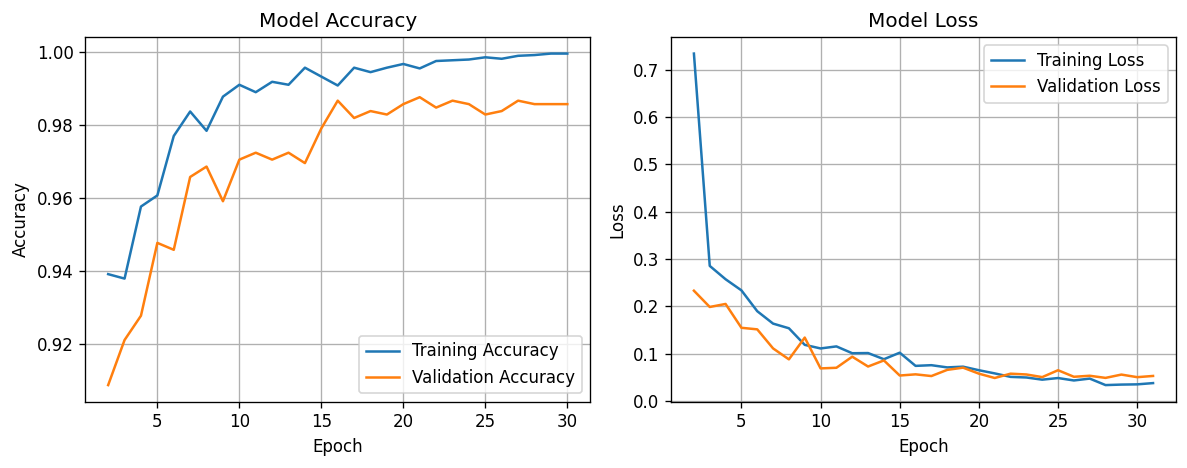

Using columns -> Train Acc: train/accuracy_top1 | Val Acc: metrics/accuracy_top1 | Train Loss: train/loss | Val Loss: val/loss


In [41]:
## Phase 4 — Training Visualizations (Accuracy/Loss, LR Schedule)

import pandas as pd
import re

# Find results.csv for this run
cands = sorted(glob.glob(f"{PROJECT}/{RUN_NAME}*/results.csv"), key=os.path.getmtime)
assert cands, "No results.csv found. Ensure training finished."
hist = pd.read_csv(cands[-1])
print("results.csv columns:", hist.columns.tolist())

# ---------- Fuzzy column picker (case-insensitive, substring allowed) ----------
def pick_one(candidates, df_cols):
    """Return first matching column from candidates (by exact or substring, case-insensitive)."""
    cols_lower = {c.lower(): c for c in df_cols}
    # exact, case-insensitive
    for cand in candidates:
        if cand.lower() in cols_lower:
            return cols_lower[cand.lower()]
    # substring, case-insensitive
    for cand in candidates:
        pat = re.compile(re.escape(cand), re.IGNORECASE)
        for c in df_cols:
            if pat.search(c):
                return c
    return None


# --- STRICT column mapping so train != val ---
train_acc_candidates = [
    "train/accuracy_top1", "train/acc", "train_accuracy", "train/accuracy"
]
val_acc_candidates = [
    "metrics/accuracy_top1",  # <- Ultralytics val acc
    "val/metrics/accuracy_top1","val/acc","val_accuracy","val/accuracy_top1",
    "val/metrics/accuracy","metrics/val_accuracy","validation_accuracy","valid/acc"
]

train_loss_candidates = ["train/loss","train_loss","train/cls_loss","metrics/train/loss","loss"]
val_loss_candidates   = ["val/loss","val/loss_epoch","val_loss","valid/loss","validation_loss"]

acc_tr_col = pick_one(train_acc_candidates, hist.columns)
acc_va_col = pick_one(val_acc_candidates,   hist.columns)
loss_tr_col= pick_one(train_loss_candidates, hist.columns)
loss_va_col= pick_one(val_loss_candidates,   hist.columns)

# Safety: ensure train != val accuracy column
if acc_tr_col == acc_va_col:
    for cand in val_acc_candidates:
        if cand in hist.columns and cand != acc_tr_col:
            acc_va_col = cand
            break

# Build epoch index and drop epochs with NaN train accuracy (first epoch may miss)
epochs = hist["epoch"] + 1 if "epoch" in hist.columns else np.arange(1, len(hist)+1)
plot_df = hist.copy()
if acc_tr_col in plot_df.columns:
    mask = ~plot_df[acc_tr_col].isna()
    if mask.any():
        plot_df = plot_df.loc[mask]
        epochs  = (plot_df["epoch"] + 1) if "epoch" in plot_df.columns else np.arange(1, len(plot_df)+1)

# ---------- Accuracy & Loss plots ----------
fig = plt.figure(figsize=(10,4))

# Accuracy plot
ax1 = plt.subplot(1,2,1)
plotted_any = False
if acc_tr_col is not None and acc_tr_col in plot_df.columns:
    ax1.plot(epochs, plot_df[acc_tr_col], label="Training Accuracy")
    plotted_any = True
if acc_va_col is not None and acc_va_col in plot_df.columns:
    ax1.plot(epochs, plot_df[acc_va_col], label="Validation Accuracy")
    plotted_any = True
if not plotted_any:
    ax1.text(0.1,0.5,"No accuracy columns found in results.csv", transform=ax1.transAxes)
ax1.set_title("Model Accuracy")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy")
if plotted_any: ax1.legend()

# Loss plot
ax2 = plt.subplot(1,2,2)
plotted_any = False
if loss_tr_col is not None and loss_tr_col in hist.columns:
    ax2.plot(hist["epoch"]+1, hist[loss_tr_col], label="Training Loss")
    plotted_any = True
if loss_va_col is not None and loss_va_col in hist.columns:
    ax2.plot(hist["epoch"]+1, hist[loss_va_col], label="Validation Loss")
    plotted_any = True
if not plotted_any:
    ax2.text(0.1,0.5,"No loss columns found in results.csv", transform=ax2.transAxes)
ax2.set_title("Model Loss")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Loss")
if plotted_any: ax2.legend()

fig.tight_layout()
plt.show()

print("Using columns ->",
      "Train Acc:", acc_tr_col,
      "| Val Acc:", acc_va_col,
      "| Train Loss:", loss_tr_col,
      "| Val Loss:", loss_va_col)

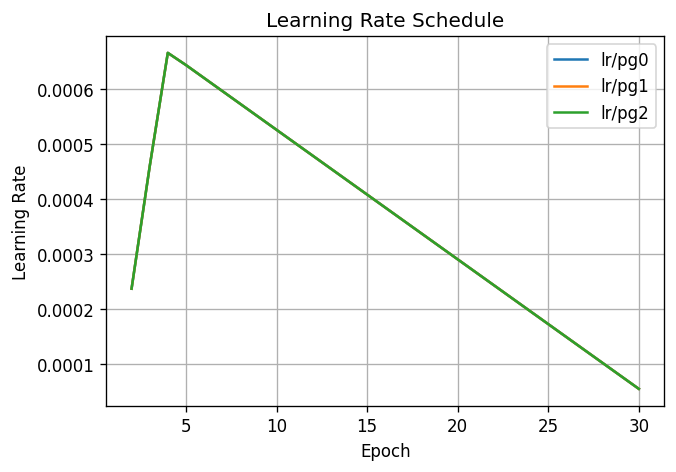

In [42]:
# Learning-rate schedule
lr_cols = [c for c in hist.columns if c.lower().startswith("lr") or c.startswith("lr/")]
if lr_cols:
    plt.figure()
    # Use the filtered plot_df and epochs for consistency
    for c in lr_cols:
        if c in plot_df.columns: # Ensure the column exists in the filtered df
             plt.plot(epochs, plot_df[c], label=c)
    plt.title("Learning Rate Schedule")
    plt.xlabel("Epoch"); plt.ylabel("Learning Rate")
    plt.legend()
    plt.show()
else:
    print("No LR columns found in results.csv")

# Evaluation & Metrics (Confusion Matrix, Per-Class Bars, Report) | Epoch 30

Ultralytics 8.3.40 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n-cls summary (fused): 112 layers, 1,531,148 parameters, 0 gradients, 3.2 GFLOPs
train: /content/drive/MyDrive/DL_Project_SPLIT/train... found 4914 images in 4 classes ✅ 
val: /content/drive/MyDrive/DL_Project_SPLIT/val... found 1052 images in 4 classes ✅ 
test: /content/drive/MyDrive/DL_Project_SPLIT/test... found 1057 images in 4 classes ✅ 


val: Scanning /content/drive/MyDrive/DL_Project_SPLIT/val... 1052 images, 0 corrupt: 100%|██████████| 1052/1052 [00:00<?, ?it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 33/33 [00:10<00:00,  3.14it/s]


                   all      0.988          1
Speed: 0.1ms preprocess, 0.5ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/bt_yolo11n_assignment32
Validation metrics: {'metrics/accuracy_top1': 0.9876425862312317, 'metrics/accuracy_top5': 1.0, 'fitness': 0.9938212931156158}
Predicting on images in: /content/drive/MyDrive/DL_Project_SPLIT/test/glioma
Predicting on images in: /content/drive/MyDrive/DL_Project_SPLIT/test/meningioma
Predicting on images in: /content/drive/MyDrive/DL_Project_SPLIT/test/pituitary
Predicting on images in: /content/drive/MyDrive/DL_Project_SPLIT/test/notumor


<Figure size 600x600 with 0 Axes>

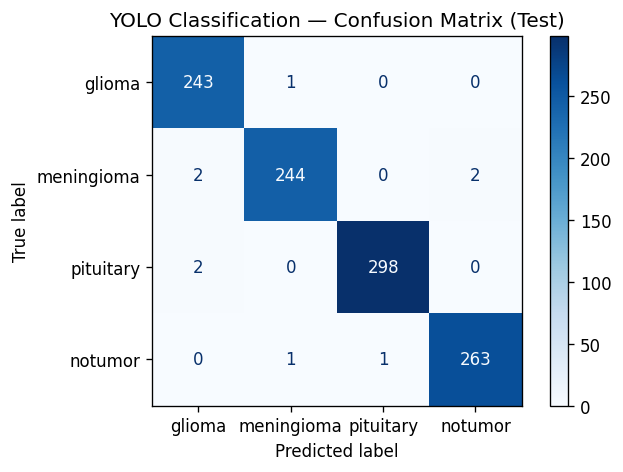

Confusion Matrix raw:
 [[243   1   0   0]
 [  2 244   0   2]
 [  2   0 298   0]
 [  0   1   1 263]]
Per-class accuracy: {'glioma': np.float64(0.9959016393442623), 'meningioma': np.float64(0.9838709677419355), 'pituitary': np.float64(0.9933333333333333), 'notumor': np.float64(0.9924528301886792)}


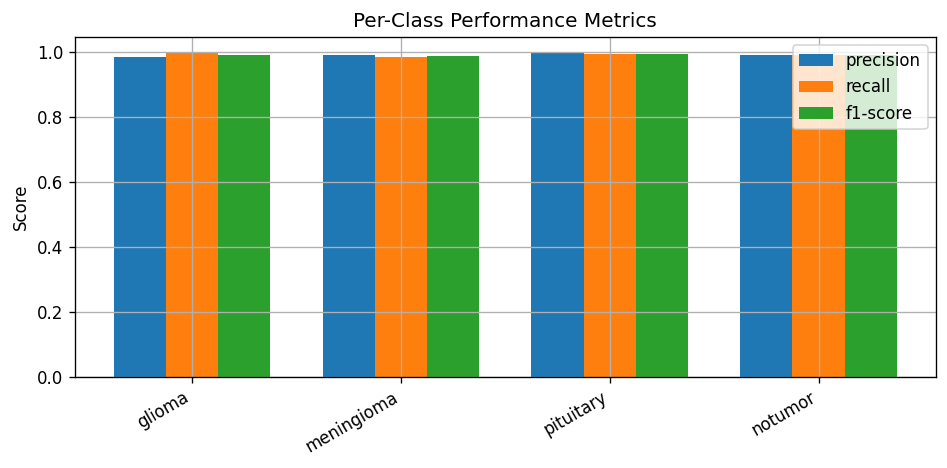

,precision,recall,f1-score,support
glioma,0.983806,0.995902,0.989817,244.000000
meningioma,0.991870,0.983871,0.987854,248.000000
pituitary,0.996656,0.993333,0.994992,300.000000
notumor,0.992453,0.992453,0.992453,265.000000
accuracy,0.991485,0.991485,0.991485,0.991485
macro avg,0.991196,0.991390,0.991279,1057.000000
weighted avg,0.991513,0.991485,0.991486,1057.000000


In [43]:
# Validate and predict on TEST set to build confusion matrix and metrics
IMG_SIZE = 224
BATCH = 32

# Quick val summary
val_results = model.val(split="val", imgsz=IMG_SIZE, batch=BATCH)
print("Validation metrics:", getattr(val_results, "results_dict", None))

# Predict on test set by iterating through class subdirectories
pred_list = []
# Map class names
y_true, y_pred = [], []
# Ultralytics model.names is a dict {index: name}
names = list(model.names.values())
idx_map = {name:i for i,name in enumerate(names)}

# Iterate through each class directory within the test split
for cls in classes:
    class_test_dir = Path(TEST_DIR) / cls
    if class_test_dir.exists() and any(class_test_dir.iterdir()): # Check if directory exists and is not empty
        print(f"Predicting on images in: {class_test_dir}")
        class_pred_list = model.predict(source=str(class_test_dir), imgsz=IMG_SIZE, stream=False, save=False, verbose=False)
        pred_list.extend(class_pred_list)

        # Collect true and predicted labels for this class
        true_idx = idx_map.get(cls, None)
        if true_idx is None:
            # fallback: use our classes list index
            if cls in classes:
                true_idx = classes.index(cls)
            else:
                continue # Skip if class name not found

        for r in class_pred_list:
             y_true.append(true_idx)
             y_pred.append(int(r.probs.top1))
    else:
        print(f"Skipping empty or non-existent directory: {class_test_dir}")


if not pred_list:
    print("No predictions were made. Check if test directories contain images.")

# Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes) # Used 'classes' instead of 'test_classes'

plt.figure(figsize=(5,5))
disp.plot(cmap='Blues', values_format='d')
plt.title('YOLO Classification — Confusion Matrix (Test)')
plt.grid(False)
plt.show()

print("Confusion Matrix raw:\n", cm)
print("Per-class accuracy:",
      {cls: cm[i,i]/cm[i].sum() if cm[i].sum() else 0.0 for i, cls in enumerate(classes)}) # Used 'classes'

# Per-class Precision/Recall/F1
report = classification_report(y_true, y_pred, target_names=classes, output_dict=True, zero_division=0)
import pandas as pd
df_rep = pd.DataFrame(report).T

# Bars for per-class metrics
metrics = ["precision","recall","f1-score"]
x = np.arange(len(classes))
plt.figure(figsize=(8,4))
for i,m in enumerate(metrics):
    plt.bar(x + i*0.25, [report[c][m] for c in classes], width=0.25, label=m)
plt.xticks(x + 0.25, classes, rotation=30, ha="right")
plt.ylabel("Score"); plt.title("Per-Class Performance Metrics")
plt.legend()
plt.tight_layout()
plt.show()

# Table view
display(df_rep.loc[classes + ["accuracy","macro avg","weighted avg"], ["precision","recall","f1-score","support"]])

## Phase 6 — Export Artifacts

In [44]:
from zipfile import ZipFile

out_zip = Path("assignment_artifacts_yolo11n.zip")
with ZipFile(out_zip, "w") as z:
    for p in glob.glob(f"{PROJECT}/{RUN_NAME}*/results.csv"):
        z.write(p, arcname=os.path.basename(p))
print("Wrote:", out_zip.resolve())


Wrote: /content/assignment_artifacts_yolo11n.zip


/usr/lib/python3.12/zipfile/__init__.py:1624: UserWarning: Duplicate name: 'results.csv'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
